In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection   
from sklearn.model_selection import train_test_split
import pickle

In [2]:
data_path = "C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Dataset/TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [3]:
data_info.head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0


In [12]:
data_info[3581:3590]

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
3581,WPAC,201708W,111.0,16.9,2017072403,38.0,42.5,995.0
3582,WPAC,201708W,110.7,16.9,2017072406,40.0,42.5,993.0
3583,WPAC,201708W,110.4,16.9,2017072409,43.0,42.5,991.0
3584,WPAC,201708W,110.1,16.9,2017072412,45.0,42.5,989.0
3585,WPAC,201708W,109.8,16.9,2017072415,45.0,43.8,989.0
3586,WPAC,201708W,109.6,17.0,2017072418,45.0,45.0,989.0
3587,WPAC,201708W,109.0,17.0,2017072421,45.0,50.6,989.0
3588,WPAC,201708W,108.4,17.0,2017072500,45.0,56.2,989.0
3589,WPAC,201708W,107.8,17.0,2017072503,45.0,50.6,989.0


In [4]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4580 entries, 0 to 4579
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data_set   4580 non-null   object 
 1   ID         4580 non-null   object 
 2   lon        4580 non-null   float64
 3   lat        4580 non-null   float64
 4   time       4580 non-null   object 
 5   Vmax       4580 non-null   float64
 6   R35_4qAVG  4580 non-null   float64
 7   MSLP       4580 non-null   float64
dtypes: float64(5), object(3)
memory usage: 322.0+ KB


In [5]:
np.shape(data_matrix)

(4580, 201, 201, 4)

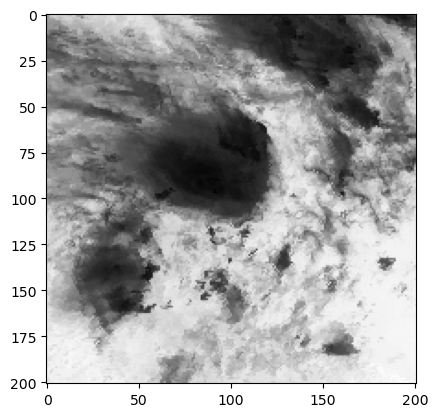

In [19]:
img = data_matrix[3581,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [7]:
data_info.isna().sum(axis=0)

data_set     0
ID           0
lon          0
lat          0
time         0
Vmax         0
R35_4qAVG    0
MSLP         0
dtype: int64

In [8]:
data_info.data_set.unique()

array(['ATLN', 'EPAC', 'IO', 'SH', 'WPAC'], dtype=object)

In [9]:
data_info.groupby('ID').count()

,data_set,lon,lat,time,Vmax,R35_4qAVG,MSLP
ID,,,,,,,
201701E,21,21,21,21,21,21,21
201701I,23,23,23,23,23,23,23
201701L,53,53,53,53,53,53,53
201701S,47,47,47,47,47,47,47
201701W,67,67,67,67,67,67,67
...,...,...,...,...,...,...,...
201729W,39,39,39,39,39,39,39
201730W,51,51,51,51,51,51,51
201731W,21,21,21,21,21,21,21


In [10]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [11]:
data_info[['ID', 'time']].groupby('ID').diff().nunique()

time    1
dtype: int64

In [12]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [13]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [14]:
train_x, test_x, train_y, test_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.2)

In [15]:
X_tensor = tf.convert_to_tensor(X_irpmw) 
y = tf.convert_to_tensor(y)

In [16]:
X_std = tf.image.per_image_standardization(X_tensor)

In [17]:
img = X_std[0,:,:,:]
print(np.mean(img), np.std(img))

-3.965676e-08 1.0


In [18]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

In [19]:
pp = Preprocessing()

In [20]:
rotated = pp(X_std[:5,:,:,:], training=True)

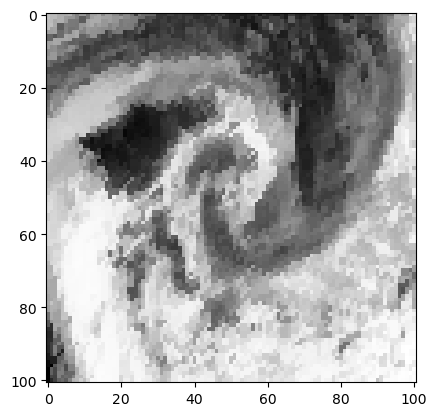

In [21]:
fig, ax = plt.subplots()
pos = ax.imshow(rotated[4,:,:,0], plt.cm.gray)

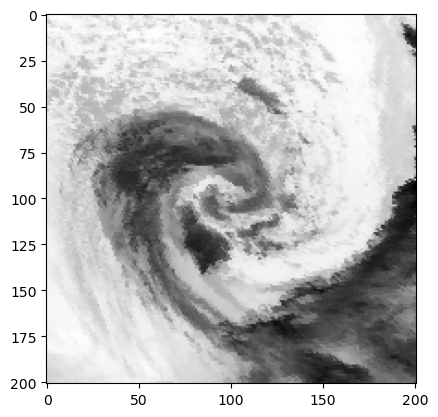

In [22]:
fig, ax = plt.subplots()
pos = ax.imshow(X_std[4,:,:,0], plt.cm.gray)

# Alexnet Model Building & Testing

In [24]:
# input_size = len(X_std)
# output_size = 10

#A function that trains and validates the model and returns the MSE
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=[['mean_squared_error']], #Computes the mean squared error between y_true and y_pred
                 )
    # initialize TimeStopping callback 
    # time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
         #callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    
    config = model.get_config()
    custom_objects = {"CustomLayer": Preprocessing}
    with keras.utils.custom_object_scope(custom_objects):
        new_model = keras.Model.from_config(config)

    # save the model to disk
    i=0
    # Keras
    new_model.save(f"C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/Alextnet_100epoch_{i}.h5")
    #Pickle
    filename = f'C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/Alexnet_100epoch_{i}.pkl'
    pickle.dump(new_model, open(filename, 'wb'))
    i+=1
    return history,val_score

In [33]:
n_epochs=100
batch_size=64
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = model_selection.KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    tr = len(train_index)
    te = len(test_index)
    train_x = X_irpmw[train_index[0]:train_index[tr-1]]
    val_x = X_irpmw[test_index[0]:test_index[te-1]]
    train_y= y[train_index[0]:train_index[tr-1]]
    val_y = y[test_index[0]:test_index[te-1]]
    history,val_score = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/100


C:\Users\Dikshant Gupta\anaconda3\envs\cyclone\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


43/43 [==============================] - 5s 58ms/step - loss: 2660.2539 - mean_squared_error: 2660.2495 - val_loss: 1637.0122 - val_mean_squared_error: 1637.0098
Epoch 2/100
43/43 [==============================] - 3s 59ms/step - loss: 2397.1599 - mean_squared_error: 2397.1594 - val_loss: 345.9876 - val_mean_squared_error: 345.9869
Epoch 3/100
43/43 [==============================] - 4s 83ms/step - loss: 599.9588 - mean_squared_error: 599.9582 - val_loss: 317.4282 - val_mean_squared_error: 317.4275
Epoch 4/100
43/43 [==============================] - 4s 95ms/step - loss: 496.4582 - mean_squared_error: 496.4575 - val_loss: 413.5971 - val_mean_squared_error: 413.5965
Epoch 5/100
43/43 [==============================] - 2s 50ms/step - loss: 422.0276 - mean_squared_error: 422.0269 - val_loss: 232.3915 - val_mean_squared_error: 232.3908
Epoch 6/100
43/43 [==============================] - 3s 63ms/step - loss: 424.1429 - mean_squared_error: 424.1422 - val_loss: 228.7573 - val_mean_squared_er

INFO:tensorflow:Assets written to: ram://0500d909-dc09-4347-a4e8-3bab584c39a9/assets


INFO:tensorflow:Assets written to: ram://0500d909-dc09-4347-a4e8-3bab584c39a9/assets




Training on Fold:  2
Epoch 1/100


C:\Users\Dikshant Gupta\anaconda3\envs\cyclone\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


65/65 [==============================] - 13s 141ms/step - loss: 947.5425 - mean_squared_error: 947.5368 - val_loss: 548.5285 - val_mean_squared_error: 548.5240
Epoch 2/100
65/65 [==============================] - 10s 148ms/step - loss: 503.4670 - mean_squared_error: 503.4628 - val_loss: 593.0781 - val_mean_squared_error: 593.0740
Epoch 3/100
65/65 [==============================] - 10s 157ms/step - loss: 443.0556 - mean_squared_error: 443.0515 - val_loss: 438.5393 - val_mean_squared_error: 438.5351
Epoch 4/100
65/65 [==============================] - 10s 149ms/step - loss: 413.6791 - mean_squared_error: 413.6749 - val_loss: 444.6626 - val_mean_squared_error: 444.6583
Epoch 5/100
65/65 [==============================] - 10s 156ms/step - loss: 408.0088 - mean_squared_error: 408.0045 - val_loss: 420.4823 - val_mean_squared_error: 420.4779
Epoch 6/100
65/65 [==============================] - 11s 167ms/step - loss: 377.9445 - mean_squared_error: 377.9401 - val_loss: 429.1040 - val_mean_squa

INFO:tensorflow:Assets written to: ram://f4de6379-8356-47aa-b83e-6997a4e49f8e/assets


INFO:tensorflow:Assets written to: ram://f4de6379-8356-47aa-b83e-6997a4e49f8e/assets




Training on Fold:  3
Epoch 1/100


C:\Users\Dikshant Gupta\anaconda3\envs\cyclone\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


43/43 [==============================] - 4s 70ms/step - loss: 1114.6743 - mean_squared_error: 1114.6671 - val_loss: 675.4747 - val_mean_squared_error: 675.4690
Epoch 2/100
43/43 [==============================] - 2s 53ms/step - loss: 757.2912 - mean_squared_error: 757.2862 - val_loss: 503.0062 - val_mean_squared_error: 503.0013
Epoch 3/100
43/43 [==============================] - 2s 58ms/step - loss: 646.1204 - mean_squared_error: 646.1153 - val_loss: 549.7379 - val_mean_squared_error: 549.7330
Epoch 4/100
43/43 [==============================] - 3s 61ms/step - loss: 471.0462 - mean_squared_error: 471.0414 - val_loss: 387.5588 - val_mean_squared_error: 387.5539
Epoch 5/100
43/43 [==============================] - 3s 66ms/step - loss: 454.7623 - mean_squared_error: 454.7574 - val_loss: 522.5987 - val_mean_squared_error: 522.5938
Epoch 6/100
43/43 [==============================] - 3s 78ms/step - loss: 470.6855 - mean_squared_error: 470.6807 - val_loss: 358.1576 - val_mean_squared_error:

INFO:tensorflow:Assets written to: ram://9a25b68c-b21f-4125-96e9-8ee88ace8f85/assets


INFO:tensorflow:Assets written to: ram://9a25b68c-b21f-4125-96e9-8ee88ace8f85/assets


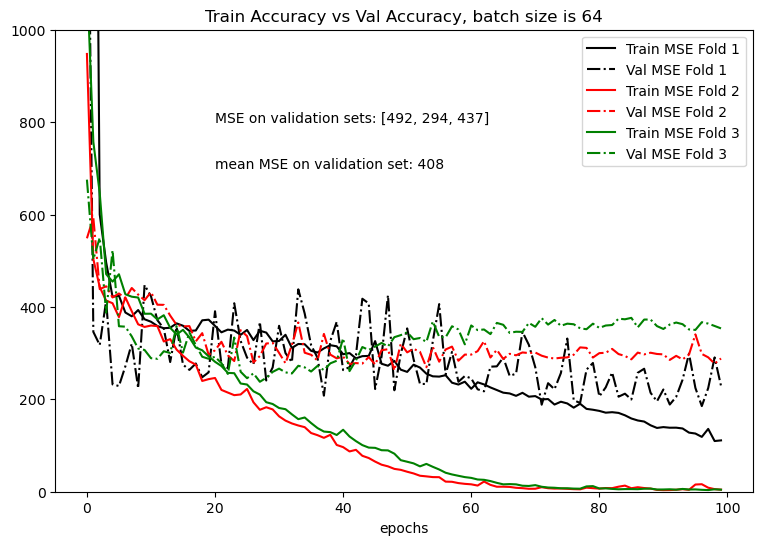

In [34]:
plt.figure(figsize=(9,6))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green','purple','orange']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
    plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()

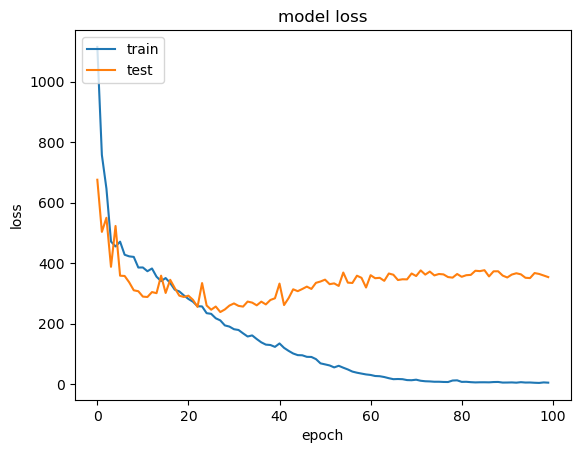

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/history_Alexnet_100epoch_437mse.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [40]:
import pickle
# save the model to disk
filename = 'C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/Alexnet_100epoch.sav'
pickle.dump(model, open(filename, 'wb'))

NameError: name 'model' is not defined

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

# VGG16 Model Building & Testing

In [23]:
# input_size = len(X_std)
# output_size = 10

#A function that trains and validates the model and returns the MSE
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        
        keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(64, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='softmax', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=[['mean_squared_error']], #Computes the mean squared error between y_true and y_pred
                 )
    # initialize TimeStopping callback 
    # time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
         #callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    
    import pickle
    # save the model to disk
    i=0
    # Keras
    model.save(f"C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/Alextnet_100epoch_{i}.h5")
    #Pickle
    filename = f'C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/Alexnet_100epoch_{i}.pkl'
    pickle.dump(model, open(filename, 'wb'))
    i+=1
    return history,val_score

In [24]:
n_epochs=20
batch_size=64
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = model_selection.KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    tr = len(train_index)
    te = len(test_index)
    train_x = X_irpmw[train_index[0]:train_index[tr-1]]
    val_x = X_irpmw[test_index[0]:test_index[te-1]]
    train_y= y[train_index[0]:train_index[tr-1]]
    val_y = y[test_index[0]:test_index[te-1]]
    history,val_score = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20


C:\Users\Dikshant Gupta\anaconda3\envs\cyclone\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


43/43 [==============================] - 36s 771ms/step - loss: 2569.2805 - mean_squared_error: 2569.2705 - val_loss: 1564.2557 - val_mean_squared_error: 1564.2516
Epoch 2/20
43/43 [==============================] - 34s 792ms/step - loss: 2569.2720 - mean_squared_error: 2569.2705 - val_loss: 1564.2527 - val_mean_squared_error: 1564.2516
Epoch 3/20
43/43 [==============================] - 34s 798ms/step - loss: 2569.2708 - mean_squared_error: 2569.2705 - val_loss: 1564.2518 - val_mean_squared_error: 1564.2516
Epoch 4/20
43/43 [==============================] - 35s 803ms/step - loss: 2569.2705 - mean_squared_error: 2569.2705 - val_loss: 1564.2516 - val_mean_squared_error: 1564.2516
Epoch 5/20
43/43 [==============================] - 32s 743ms/step - loss: 2569.2705 - mean_squared_error: 2569.2705 - val_loss: 1564.2516 - val_mean_squared_error: 1564.2516
Epoch 6/20
43/43 [==============================] - 35s 818ms/step - loss: 2569.2705 - mean_squared_error: 2569.2705 - val_loss: 1564.25

INFO:tensorflow:Assets written to: ram://dc66e28c-b65a-4485-9c29-5d915ac20051/assets


INFO:tensorflow:Assets written to: ram://dc66e28c-b65a-4485-9c29-5d915ac20051/assets




Training on Fold:  2
Epoch 1/20


C:\Users\Dikshant Gupta\anaconda3\envs\cyclone\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


65/65 [==============================] - 52s 767ms/step - loss: 2983.1101 - mean_squared_error: 2983.1035 - val_loss: 2287.1438 - val_mean_squared_error: 2287.1418
Epoch 2/20
65/65 [==============================] - 51s 778ms/step - loss: 2983.1040 - mean_squared_error: 2983.1035 - val_loss: 2287.1418 - val_mean_squared_error: 2287.1418
Epoch 3/20
65/65 [==============================] - 51s 785ms/step - loss: 2983.1038 - mean_squared_error: 2983.1035 - val_loss: 2287.1418 - val_mean_squared_error: 2287.1418
Epoch 4/20
65/65 [==============================] - 50s 773ms/step - loss: 2983.1035 - mean_squared_error: 2983.1035 - val_loss: 2287.1418 - val_mean_squared_error: 2287.1418
Epoch 5/20
65/65 [==============================] - 50s 775ms/step - loss: 2983.1035 - mean_squared_error: 2983.1035 - val_loss: 2287.1418 - val_mean_squared_error: 2287.1418
Epoch 6/20
65/65 [==============================] - 50s 763ms/step - loss: 2983.1035 - mean_squared_error: 2983.1035 - val_loss: 2287.14

INFO:tensorflow:Assets written to: ram://a03db10b-57b3-4383-94ae-3b31e6814615/assets


INFO:tensorflow:Assets written to: ram://a03db10b-57b3-4383-94ae-3b31e6814615/assets




Training on Fold:  3
Epoch 1/20


C:\Users\Dikshant Gupta\anaconda3\envs\cyclone\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


43/43 [==============================] - 37s 814ms/step - loss: 3027.1555 - mean_squared_error: 3027.1455 - val_loss: 2545.2981 - val_mean_squared_error: 2545.2942
Epoch 2/20
43/43 [==============================] - 33s 772ms/step - loss: 3027.1470 - mean_squared_error: 3027.1455 - val_loss: 2545.2952 - val_mean_squared_error: 2545.2942
Epoch 3/20
43/43 [==============================] - 34s 788ms/step - loss: 3027.1458 - mean_squared_error: 3027.1455 - val_loss: 2545.2944 - val_mean_squared_error: 2545.2942
Epoch 4/20
43/43 [==============================] - 34s 782ms/step - loss: 3027.1458 - mean_squared_error: 3027.1455 - val_loss: 2545.2942 - val_mean_squared_error: 2545.2942
Epoch 5/20
43/43 [==============================] - 33s 773ms/step - loss: 3027.1455 - mean_squared_error: 3027.1455 - val_loss: 2545.2942 - val_mean_squared_error: 2545.2942
Epoch 6/20
43/43 [==============================] - 35s 812ms/step - loss: 3027.1455 - mean_squared_error: 3027.1455 - val_loss: 2545.29

INFO:tensorflow:Assets written to: ram://bbb29bb2-6d24-4ac6-a395-e4f091499ebc/assets


INFO:tensorflow:Assets written to: ram://bbb29bb2-6d24-4ac6-a395-e4f091499ebc/assets


In [25]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history_VGG16_20epoch.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
import pickle
# save the model to disk
filename = 'VGG16_20epoch_2783.3_mse.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

# Mixed Model Building & Testing

In [23]:
# from pyimagesearch import datasets
# from pyimagesearch import models
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import numpy as np
import argparse
import locale
import os

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization,Input,Flatten,Dense,Dropout,Activation,MaxPooling2D,Conv2D,concatenate
from tensorflow.keras.optimizers import Adam

In [24]:
x_img = data_matrix[:,:,:,0::3]
x_num = pd.DataFrame(data_info, columns = ["lon", "lat", "R35_4qAVG", "MSLP"])
y = pd.DataFrame(data_info, columns = ["Vmax"])

In [25]:
y.head()

,Vmax
0,55.0
1,55.0
2,55.0
3,55.0
4,55.0


In [26]:
x_img_train = x_img[:3580]
x_img_test = x_img[3581:]
x_num_train = x_num[:3580]
x_num_test = x_num[3581:]
y_train = y[:3580]
y_test = y[3581:]

In [27]:
train_num_x = tf.convert_to_tensor(x_num_train)

In [28]:
train_num_x.shape

TensorShape([3580, 4])

In [29]:
def create_num_model(dim, regress=False):
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    return model

In [30]:
def create_img_model(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
            
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)
        x = Dense(4)(x)
        x = Activation("relu")(x)
        
        model = Model(inputs, x)
        return model

In [31]:
# model_num = models.create_num_model(4, regress=False)
# model_img = models.create_img_model(201, 201, 2, regress=False)

model_num = create_num_model(4, regress=False)
model_img = create_img_model(201, 201, 2, regress=False)

combined_input = concatenate([model_num.output, model_img.output])

x = Dense(4, activation="relu")(combined_input)
x = Dense(1, activation="relu")(x)

model = Model(inputs=[model_num.input, model_img.input], outputs=x)

In [32]:
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("[INFO] training model...")
history = model.fit(
    x=[x_num_train, x_img_train], y=y_train,
    validation_data=([x_num_test, x_img_test], y_test),
    epochs=100, batch_size=64)

[INFO] training model...
Epoch 1/100
56/56 [==============================] - 21s 334ms/step - loss: 6988.2485 - val_loss: 1998.4202
Epoch 2/100
56/56 [==============================] - 16s 277ms/step - loss: 1042.7158 - val_loss: 700.6774
Epoch 3/100
56/56 [==============================] - 17s 301ms/step - loss: 643.2847 - val_loss: 431.9961
Epoch 4/100
56/56 [==============================] - 17s 307ms/step - loss: 539.0750 - val_loss: 413.3245
Epoch 5/100
56/56 [==============================] - 19s 338ms/step - loss: 491.4643 - val_loss: 417.0926
Epoch 6/100
56/56 [==============================] - 15s 275ms/step - loss: 448.6319 - val_loss: 431.5353
Epoch 7/100
56/56 [==============================] - 16s 279ms/step - loss: 393.6442 - val_loss: 451.8446
Epoch 8/100
56/56 [==============================] - 16s 287ms/step - loss: 328.4153 - val_loss: 383.0100
Epoch 9/100
56/56 [==============================] - 16s 291ms/step - loss: 259.0828 - val_loss: 335.8213
Epoch 10/100
56/56

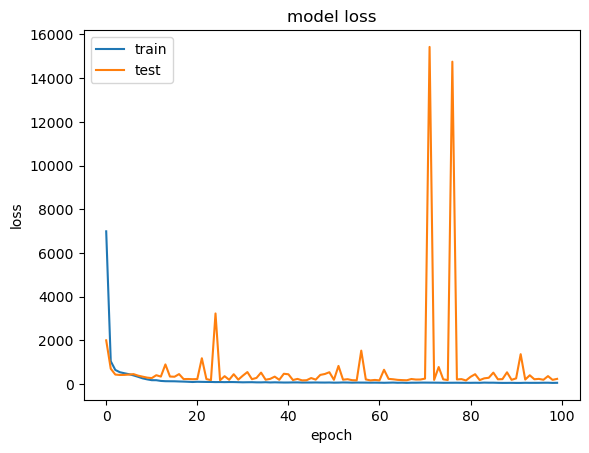

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# make predictions on the testing data
print("[INFO] predicting Cyclone Intensity...")
preds = model.predict([x_num_test, x_img_test])

[INFO] predicting house prices...
32/32 [==============================] - 2s 56ms/step


In [ ]:
# Keras
model.save("C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/MixedModel_100epoch.h5")

In [ ]:
import pickle
# save the model to disk
filename = "C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/MixedModel_100epoch.pkl"
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'C:/Users/Dikshant Gupta/Desktop/VIT/SEM 6/CSE1901_TARP_Prj_NIL/Code/Model_hist_details/AlexNet2/history_MixedModel_100epoch.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)